In [1]:
import backtrader as bt
import pandas as pd

import ccxt
import datetime

import matplotlib.pyplot as plt


In [2]:

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

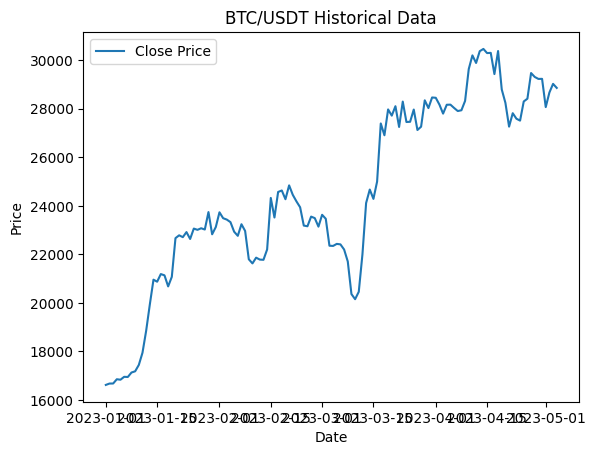

In [3]:

# Configure CCXT
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'  # Use '1h' for hourly data, '1m' for minute data, etc.
since = exchange.parse8601('2023-01-01T00:00:00Z')

# Fetch historical data using CCXT
ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('Date', inplace=True)
df.drop(columns=['timestamp'], inplace=True)

# Create a Backtrader data feed
data = bt.feeds.PandasData(dataname=df)



# Plot the price chart
fig, ax = plt.subplots()
ax.plot(df.index, df['close'], label='Close Price')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('BTC/USDT Historical Data')

# Show legend and plot
ax.legend()
plt.show()

In [4]:
def run_backtest(strategy, fast_sma_period, slow_sma_period, cash, plot=True):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy, fast_sma_period=fast_sma_period, slow_sma_period=slow_sma_period)
    cerebro.adddata(data)
    cerebro.broker.setcash(cash)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    cerebro.broker.setcommission(commission=0.001)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    if plot:
        cerebro.plot(style='candlestick',iplot=False)
        #cerebro.plot()

In [5]:
%matplotlib inline

fast_sma_period = 10
slow_sma_period = 30
initial_cash = 10000

run_backtest(
    SMACrossover,
    fast_sma_period=fast_sma_period,
    slow_sma_period=slow_sma_period,
    cash=initial_cash,
    plot=True
)

NameError: name 'SMACrossover' is not defined

Starting Portfolio Value: 1000.00
2023-02-03, Close, 23431.90
2023-02-03, BUY CREATE, 23431.90
2023-02-04, Order Canceled/Margin/Rejected
2023-02-04, Close, 23326.84
2023-02-04, BUY CREATE, 23326.84
2023-02-05, Order Canceled/Margin/Rejected
2023-02-05, Close, 22932.91
2023-02-06, Close, 22762.52
2023-02-07, Close, 23240.46
2023-02-07, BUY CREATE, 23240.46
2023-02-08, Order Canceled/Margin/Rejected
2023-02-08, Close, 22963.00
2023-02-09, Close, 21796.35
2023-02-10, Close, 21625.19
2023-02-11, Close, 21862.55
2023-02-12, Close, 21783.54
2023-02-13, Close, 21773.97
2023-02-14, Close, 22199.84
2023-02-15, Close, 24324.05
2023-02-15, BUY CREATE, 24324.05
2023-02-16, Order Canceled/Margin/Rejected
2023-02-16, Close, 23517.72
2023-02-16, BUY CREATE, 23517.72
2023-02-17, Order Canceled/Margin/Rejected
2023-02-17, Close, 24569.97
2023-02-17, BUY CREATE, 24569.97
2023-02-18, Order Canceled/Margin/Rejected
2023-02-18, Close, 24631.95
2023-02-18, BUY CREATE, 24631.95
2023-02-19, Order Canceled/Ma

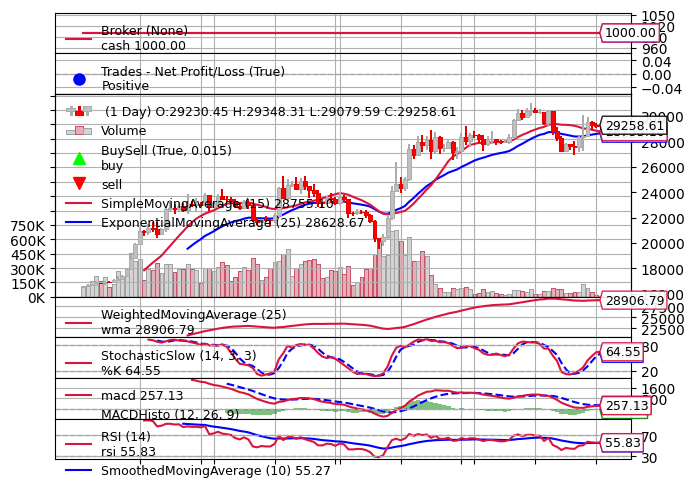

[[<Figure size 640x480 with 8 Axes>]]

In [9]:
%matplotlib inline

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=100)

# Set the commission
cerebro.broker.setcommission(commission=0.01)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot(style='candlestick',iplot=False)